In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('ignore')

# Multivariate GRU

**Changes**:

* Adaptive learning rates
* Playing with network architecture


In [4]:
import numpy as np
import pandas as pd

from tqdm import tqdm
from config import interim_data_dir, raw_data_dir

from src.utils import read_shapefile

## Load Dataset

In [36]:
import numpy as np
import pandas as pd

from tqdm import tqdm
from config import interim_data_dir, raw_data_dir

from src.utils import read_shapefile

from config import processed_data_dir

dataset_version = 'v5.1'

train_features_df = pd.read_csv(processed_data_dir/'VI_datasets'/dataset_version/'train.csv', index_col=0)
test_features_df = pd.read_csv(processed_data_dir/'VI_datasets'/dataset_version/'test.csv', index_col=0)
class_weight = 1-train_features_df.y.value_counts(normalize=True)

## Process Data

In [37]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def impute_nan_inf(df):
    """
    Impute bad values (nan and inf) using
    the median of that feature on that time stamp
    for all farms
    
    TODO: This can be improved
    """
    
    # replace all nans variants with np.nan
    df = df.replace([np.nan, None, np.inf, -np.inf], np.nan)

    # replace all nans with the median value of all farms on that timestamp
    for ts, ts_df in df.groupby('time'):
        df.loc[ts_df.index] = ts_df.fillna(ts_df.median())
        
    return df


def transform_dataset(features_df):
    """
    Create a data array in the shape (n_ids, n_time, n_features)
    
    If it is the training set, also return dictionary mapping index
    in dataset to correct label.
    
    """
    
    n_ids = features_df.farm_id.nunique()

    feature_cols = [col for col in features_df.columns if col not in ['farm_id','y','time']]
    
    n_features = len(feature_cols)

    data = np.ndarray((n_ids, 11, n_features))
    
    classes = {}
    for i, (farm_id, farm_df) in enumerate(features_df.groupby(['farm_id'])):

        data[i,:,:] = farm_df[feature_cols].values
        
        if 'y' in features_df.columns:
            c = farm_df['y'].unique()
            classes[i] = c[0]
            
    return data, classes
    

        
train_features_df = impute_nan_inf(train_features_df)
test_features_df = impute_nan_inf(test_features_df)


# Make copies to compare before / after normalization
train_copy = train_features_df.copy()
test_copy = test_features_df.copy()


times = train_features_df['time'].unique()
feature_cols = [col for col in test_features_df.columns if col not in ['farm_id','time']]

for ts in times:
    scaler = StandardScaler()
    
    train_ts_df = train_copy[train_copy.time == ts]
    test_ts_df = test_copy[test_copy.time == ts]
    
    train_features_df.loc[train_ts_df.index, feature_cols] = scaler.fit_transform(train_ts_df[feature_cols])
    test_features_df.loc[test_ts_df.index, feature_cols] = scaler.transform(test_ts_df[feature_cols])
    
    
train_data, train_labels_dict = transform_dataset(train_features_df)
test_data, _ = transform_dataset(test_features_df)

print('Train data:\t\t',train_data.shape)
print('Test data:\t\t',test_data.shape)

Train data:		 (2494, 11, 110)
Test data:		 (1074, 11, 110)


## Start Modelling Process

### Create validation set

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

seed = 420

# Copy for later
data = train_data.copy()

train_labels = list(train_labels_dict.values())
train_indexes = list(train_labels_dict.keys())
train_idx, val_idx, train_labels, val_labels = train_test_split(train_indexes, train_labels, stratify=train_labels, test_size=0.2, random_state=seed)

le = LabelEncoder()
train_labels_enc = le.fit_transform(np.array(train_labels).reshape(-1,1))
val_labels_enc = le.transform(np.array(val_labels).reshape(-1,1))

train_data = data[train_idx,:, :]
val_data = data[val_idx,:, :]

print('train data : ',train_data.shape)
print('val data : ',val_data.shape)

train data :  (1995, 11, 110)
val data :  (499, 11, 110)


### Create model

In [123]:
import tensorflow as tf
import keras
from keras import models, layers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


from src.visualization.tf_viz import PlotLosses
# from src.models.sgdr import SGDRScheduler

## Set trainig params
epoch_size=2000
batch_size=128

def get_model(n_features):

    GRU_cells = 16
    recurrent_activation = 'hard_sigmoid'
    recurrent_dropout = 0.6093571771811351

    model = models.Sequential()
    model.add(layers.Dense(8, activation='relu', input_shape=(11, n_features)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    model.add(layers.GRU(GRU_cells,input_shape=(11, n_features), 
                         return_sequences=True,
                         recurrent_activation=recurrent_activation, 
                         recurrent_dropout=recurrent_dropout))
    model.add(layers.GRU(GRU_cells,input_shape=(11, n_features), 
                         return_sequences=True,
                         recurrent_activation=recurrent_activation, 
                         recurrent_dropout=recurrent_dropout))
    model.add(layers.Flatten())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(9, activation='softmax'))
    

    return model

## Find Learning Rate

In [109]:
# %%capture
# from keras_lr_finder import LRFinder

# optimizer = keras.optimizers.RMSprop()
# model = get_model(train_data.shape[-1])
# model.compile(optimizer=optimizer, loss=keras.metrics.sparse_categorical_crossentropy, metrics=[keras.metrics.sparse_categorical_crossentropy])

# #model is a Keras model
# lr_finder = LRFinder(model)

# lr_finder.find(train_data, train_labels_enc, start_lr=3e-6, end_lr=3e-2, batch_size=512, epochs=50)

In [110]:
# Plot the loss, ignore 20 batches in the beginning and 5 in the end
# lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)

In [111]:
# lr_finder.plot_loss_change(sma=20, n_skip_beginning=20, n_skip_end=5, y_lim=(-0.04, 0.01))

In [124]:
from src.models.clr_callback import CyclicLR
from keras.callbacks import ModelCheckpoint

from config import models_dir

lr = 3e-4
batch_size = 128

# Get the model
model = get_model(train_data.shape[-1])

# Choose optimizer
# optimizer = keras.optimizers.RMSprop(lr)
optimizer = keras.optimizers.Adam(lr)


# Choose callbacks
checkpoint = ModelCheckpoint(str(models_dir / 'gru_v_5.1_weights.hdf5'), save_best_only=True, mode='min', monitor='val_loss')
plot_losses = PlotLosses()
es = EarlyStopping(monitor='val_loss', verbose=1, patience=100)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=50, verbose=1, factor=0.5, min_delta=0.001,)


# Adaptive learning rates
clr = CyclicLR(base_lr=1e-4, max_lr=2e-3, step_size=train_data.shape[0] * 2)

callbacks = [
    plot_losses, 
    checkpoint,
#     clr
    es, 
    reduce_lr
]

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_71 (Dense)             (None, 11, 8)             888       
_________________________________________________________________
batch_normalization_68 (Batc (None, 11, 8)             32        
_________________________________________________________________
dropout_68 (Dropout)         (None, 11, 8)             0         
_________________________________________________________________
dense_72 (Dense)             (None, 11, 64)            576       
_________________________________________________________________
batch_normalization_69 (Batc (None, 11, 64)            256       
_________________________________________________________________
dropout_69 (Dropout)         (None, 11, 64)            0         
_________________________________________________________________
gru_47 (GRU)                 (None, 11, 16)            3888      
__________

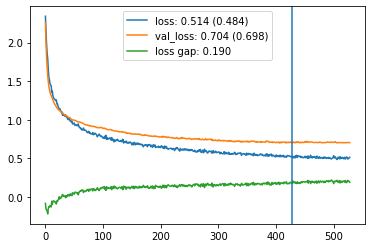

Epoch 00529: early stopping


In [113]:
model.fit(train_data, 
          train_labels_enc,
          batch_size=batch_size,
          validation_data=(val_data, val_labels_enc), 
          class_weight=class_weight,
          verbose=0,
          epochs=epoch_size, 
          callbacks=callbacks)

In [114]:
from keras.models import load_model

model = load_model('../models/gru_v_5.1_2_weights.hdf5')

In [115]:
from sklearn.metrics import log_loss

val_preds = model.predict(val_data)
train_preds = model.predict(train_data)
print('val loss: ',log_loss(val_labels_enc, val_preds))
print('train loss: ',log_loss(train_labels_enc, train_preds))

val loss:  0.6984896695885802
train loss:  0.4732827899426721


### Confusion matrix

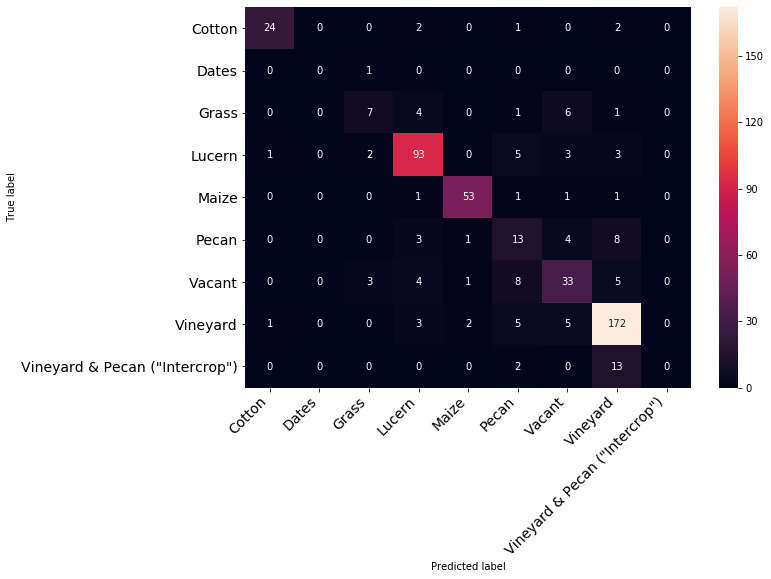

In [116]:
from sklearn.metrics import confusion_matrix
from src.visualization.visualize import print_confusion_matrix

class_labels = pd.read_csv(raw_data_dir / 'crop_id_list.csv', index_col=0).sort_index().crop

val_preds = model.predict_classes(val_data)

cm = confusion_matrix(val_labels_enc, val_preds)
print_confusion_matrix(cm, class_names=class_labels);

## Make Submission

### First retrain on all data


In [117]:
all_data = np.vstack([train_data, val_data])
all_labels = np.array(list(train_labels_enc) + list(val_labels_enc))

class_weight = (1 - pd.Series(all_labels).value_counts(normalize=True)).to_dict()

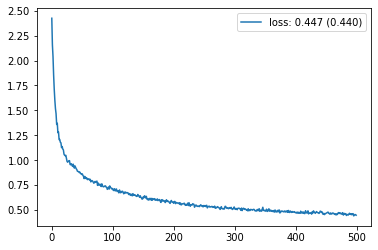

In [125]:
model = get_model(all_data.shape[-1])
optimizer = keras.optimizers.Adam(lr)
model.compile(optimizer=optimizer,
              loss=keras.metrics.sparse_categorical_crossentropy,
              metrics=[keras.metrics.sparse_categorical_crossentropy])

model.fit(all_data, 
          all_labels,
          batch_size=128, 
          class_weight=class_weight,
          verbose=2,
          epochs=500, 
          callbacks=[plot_losses, es, reduce_lr])

In [126]:
def make_sub(predictions, ids_list):
    
    sub_df = pd.read_csv(raw_data_dir / 'sample_submission_fixed.csv')

    new_sub = sub_df.copy().set_index('field_id')

    new_sub.loc[ids_list] = predictions
    
    return new_sub

predictions = model.predict(test_data)
test_ids = sorted(list(test_features_df.farm_id.unique()))
sub_df = make_sub(predictions, test_ids)
sub_df.head()

,crop_id_1,crop_id_2,crop_id_3,crop_id_4,crop_id_5,crop_id_6,crop_id_7,crop_id_8,crop_id_9
field_id,,,,,,,,,
5,1.775022e-05,0.000036,0.000389,0.000862,0.000034,0.006598,0.000094,0.824775,0.167195
6,3.039292e-07,0.000009,0.000132,0.000231,0.000021,0.005438,0.000127,0.872594,0.121448
10,9.308285e-06,0.000049,0.000665,0.000712,0.000003,0.009034,0.000077,0.850357,0.139094
18,1.323486e-07,0.000001,0.000001,0.000001,0.000001,0.001060,0.000001,0.874727,0.124206
23,7.254404e-07,0.000006,0.000007,0.000005,0.000002,0.003158,0.000006,0.870406,0.126411


### Save submission file

In [127]:
from config import subs_dir

fname = 'gru_vi_data_v5.1_3'
sub_df.to_csv(subs_dir / f'{fname}.csv')

### Save model architecture

In [128]:
with open(subs_dir / 'architectures' / f'{fname}.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))